# OD calculation
Notebook calculating the optical density and fitting the marginals (non-normalized) to a gaussian distribution.

This notebook includes some pointers on using `scikit-images` for image processing, which could be helpful.

It is important to note that the axes of images are flipped, ordered `[y][x]`.

In [11]:
#Imports

#path tools
from pathlib import Path
import os

#image processing
from skimage.io import imread, imshow
from skimage.measure import label, regionprops
from scipy.ndimage import median_filter

#other utils
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats.contingency import margins #compute marginals
from scipy.optimize import curve_fit

from itertools import product

wd = Path(os.getcwd()) #current working directory
np.seterr(divide='ignore'); #doesn't end up mattering, suppress the annoying warning

In [3]:
example_dir = wd / "test_data" #test data directory

#each image has an accompanying background image with just noise
im0 = imread(example_dir / "img_0.tif")
im0_background = imread(example_dir / "img_2.tif")

#I am unclear on why the second image is necessary
im1 = imread(example_dir / "img_1.tif")
im1_background = imread(example_dir / "img_3.tif")

/tmp/ipykernel_197892/2697091872.py:10: RuntimeWarning: invalid value encountered in divide
  I_div_arr = np.divide(I_arr, I0_arr)


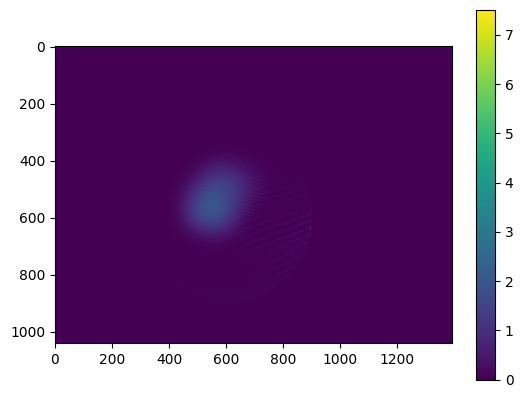

In [4]:
#get background intensity value with noise subtracted
I0_arr=np.subtract(np.array(im0),
                    np.array(im0_background)).astype(int)

#get foreground intensity with noise subtracted
I_arr=np.subtract(np.array(im1),
                    np.array(im1_background)).astype(int)


I_div_arr = np.divide(I_arr, I0_arr)
od_arr = np.log(I_div_arr)

def incircle(center, radius, pt):
    return (pt[0]-center[0])**2 + (pt[1]-center[1])**2 < radius**2

#first pass, just clip anything not within the aperture
for i,row in enumerate(od_arr):
    for j, pixel in enumerate(row):
        if pixel < 0 or not incircle((600,600),300,(i,j)):
            od_arr[i][j] = 0

img1 = plt.imshow(od_arr)
plt.colorbar(img1)

## Create image mask
A couple parameters can be used to mask out the unwanted data. First, `lower_mask` and `upper_mask` are just rough cutoff values. The `value_mask` parameter tries to get as much of the blob as possible while cutting off the noise. This can be set low, because the median mask will eliminate the outliers.

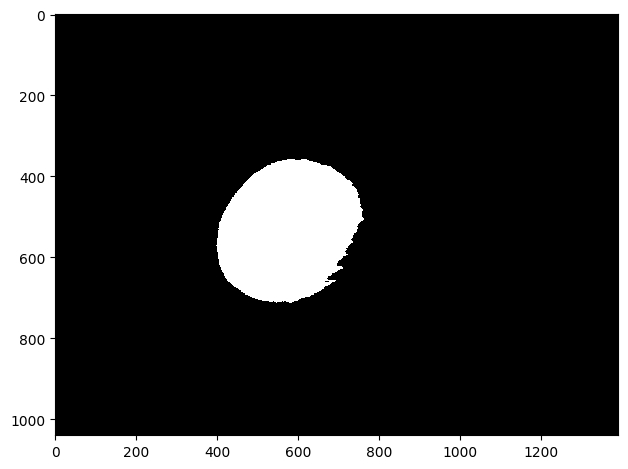

In [5]:
lower_mask = od_arr[:,:] > 0
upper_mask = od_arr[:,:] < 5
value_mask = od_arr[:,:] > .05
mask = lower_mask*upper_mask*value_mask

mask_filtered = median_filter(lower_mask*upper_mask*value_mask, 20)
imshow(mask_filtered)

## Get blob bounding box
THe `label` function is used to separate contiguous regions of the image and returns useful properties regarding their shape, location, and orientation.

In [6]:
blobs = label(mask_filtered)
props = regionprops(blobs) #generate a properties dictionary
bbox = props[0].bbox #get the bounding box
bbox 

(357, 398, 715, 762)

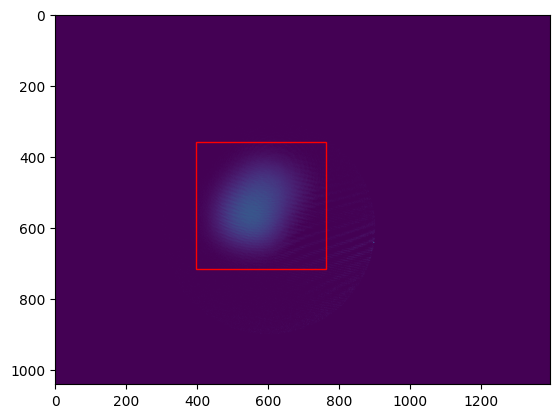

In [7]:
#draw bounding box
fig, ax = plt.subplots()
rect = plt.Rectangle((bbox[1],bbox[0]),bbox[3]-bbox[1], bbox[2]-bbox[0])
rect.set(fill=False, color = "red")
ax.add_artist(rect)
ax.imshow(od_arr)

In [8]:
#extract blob rectangle from image
blob_arr = od_arr[bbox[0]:bbox[2], bbox[1]:bbox[3]]
#apply a median filter
blob_arr = median_filter(blob_arr, 3)

In [9]:
x, y = margins(blob_arr)
x = x.T[0]
y = y[0]

mu1 = np.sum([i*xi for i,xi in enumerate(x)])/np.sum(x)
mu2 = np.sum([i*xi for i,xi in enumerate(x)])/np.sum(x)

In [52]:
#compute marginals and fit to a gaussian
def gaussian_fit(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def bivariate_gaussian(X, A, sigma1, sigma2, rho):
    def z():
        return (X[0]-mu1)**2/sigma1**2-2*rho*(X[0]-mu1)*(X[1]-mu2)/(sigma1*sigma2)+(X[1]-mu2)**2/sigma2**2
        
    return np.exp(- z()/(2*(1-rho**2)))

popt, pcov = curve_fit(bivariate_gaussian, np.array(list(product(range(len(x)), range(len(y))))).T, blob_arr.flatten(), p0 =[350, 60, 60, 0])

In [53]:
popt

array([ 3.50000000e+02,  1.03549457e+02,  9.91267559e+01, -2.55258737e-01])

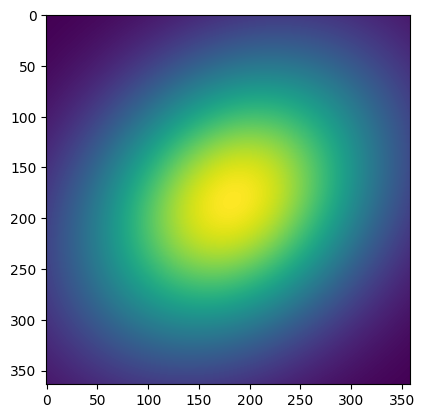

In [41]:
popt

array([ 3.50000000e+02,  7.37250656e+01,  4.45740370e+02, -2.90213661e-02])

In [27]:
xlist = np.array([[(a,b) for a in range(len(y))] for b in range(len(x))])

In [28]:
xlist.shape

(358, 364, 2)

In [29]:
blob_arr.shape

(358, 364)

In [20]:
[[(a,b) for b in range(len(y))] for a in range(len(x))]

[[(0, 0),
  (0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (0, 6),
  (0, 7),
  (0, 8),
  (0, 9),
  (0, 10),
  (0, 11),
  (0, 12),
  (0, 13),
  (0, 14),
  (0, 15),
  (0, 16),
  (0, 17),
  (0, 18),
  (0, 19),
  (0, 20),
  (0, 21),
  (0, 22),
  (0, 23),
  (0, 24),
  (0, 25),
  (0, 26),
  (0, 27),
  (0, 28),
  (0, 29),
  (0, 30),
  (0, 31),
  (0, 32),
  (0, 33),
  (0, 34),
  (0, 35),
  (0, 36),
  (0, 37),
  (0, 38),
  (0, 39),
  (0, 40),
  (0, 41),
  (0, 42),
  (0, 43),
  (0, 44),
  (0, 45),
  (0, 46),
  (0, 47),
  (0, 48),
  (0, 49),
  (0, 50),
  (0, 51),
  (0, 52),
  (0, 53),
  (0, 54),
  (0, 55),
  (0, 56),
  (0, 57),
  (0, 58),
  (0, 59),
  (0, 60),
  (0, 61),
  (0, 62),
  (0, 63),
  (0, 64),
  (0, 65),
  (0, 66),
  (0, 67),
  (0, 68),
  (0, 69),
  (0, 70),
  (0, 71),
  (0, 72),
  (0, 73),
  (0, 74),
  (0, 75),
  (0, 76),
  (0, 77),
  (0, 78),
  (0, 79),
  (0, 80),
  (0, 81),
  (0, 82),
  (0, 83),
  (0, 84),
  (0, 85),
  (0, 86),
  (0, 87),
  (0, 88),
  (0, 89),
  (0, 90),
  (0, 91)

In [16]:
blob_arr

array([[0.        , 0.        , 0.        , ..., 0.00882618, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05691736],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05691736],
       ...,
       [0.00944889, 0.00282088, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00714799, 0.        , 0.        , ..., 0.07784249, 0.05106548,
        0.00444445],
       [0.        , 0.        , 0.        , ..., 0.12638154, 0.08022117,
        0.05106548]])

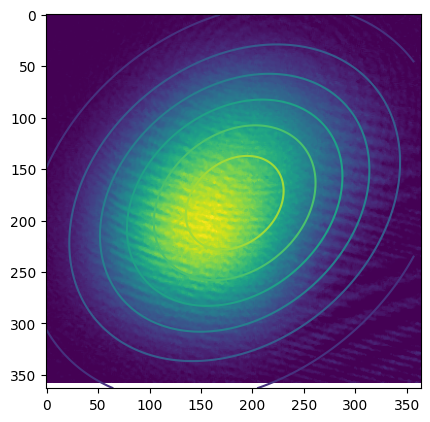

In [63]:
fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1,0])
ax.imshow(blob_arr)
ax.contour([[bivariate_gaussian((a,b), *popt) for a in range (len(x))] for b in range(len(y))])

In [186]:
print("OD max:", np.max(blob_arr))

OD max: 2.0828603484286212
